In [1242]:
# !pip install git+https://github.com/gaarangoa/samecode.git
# !pip install seaborn
# !pip install scipy
# !pip install scikit-learn
# !pip uninstall samv2 --yes

# Identification of disease in corns using AI
@UmayuxLabs

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image

In [5]:
from sam2.build_sam import load_model
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.utils.misc import variant_to_config_mapping
from sam2.utils.visualization import show_masks

In [6]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [361]:
from samecode.plot.pyplot import subplots
import seaborn as sns

In [1034]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle

In [1191]:
def object2coords(obj):
    coords = []
    M, N = obj.shape[:2]
    m_indices, n_indices = np.indices((M, N))
    m_indices = m_indices.flatten()
    n_indices = n_indices.flatten()
    
    pixels = obj.reshape(-1, 3)
    indices = np.stack((m_indices, n_indices), axis=-1)
    pixels = np.concatenate([pixels, indices], axis=1)
    
    pixels = pixels[pixels[:, :3].sum(axis=1) != 0, :]
    
    return pixels

## Load Segmentation Foundation Model
We use SAM2 tiny model

In [372]:
model = load_model("../models/tiny", apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(
    model,
    points_per_side=16,
    points_per_batch=32,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.7,
)

In [898]:
%%time
image = Image.open('../data/1-2.jpg')
image = np.array(image.convert("RGB"))

masks = mask_generator.generate(image)

CPU times: user 33.8 s, sys: 9.66 s, total: 43.4 s
Wall time: 5.95 s


In [1192]:
objects = []
for obj in range(len(masks)):
    mask = masks[obj]['segmentation']
    x1, x2, y1, y2 = [int(i) for i in masks[obj]['bbox']]
    
    simg = np.array([image[x2:x2+y2, x1:x1+y1, i] * mask[x2:x2+y2, x1:x1+y1] for i in range(3)])
    simg = np.transpose(simg, (1, 2, 0))
    coords = object2coords(simg)
    meanI = coords.mean(axis=0)
    objects.append({
        'segmented_image': simg,
        'area': masks[obj]['area'],
        'predicted_iou':  masks[obj]['predicted_iou'],
        'stability_score':  masks[obj]['stability_score'],
        'coords': coords,
        'mean_R': meanI[0],
        'mean_B': meanI[1],
        'mean_G': meanI[2]
    })

In [1193]:
len(masks)

22

## Identify disease and good regions in the corn

In [1194]:
coords = objects[2]['coords']

In [1195]:
coords.shape

(10102, 5)

In [1196]:
(coords[:, 4]>25)

array([ True,  True,  True, ...,  True,  True,  True])

In [1232]:
labels = -1 * np.ones(coords.shape[0])
labels[coords[:, 3] < 20] = 0
labels[(coords[:, 3]>25) & (coords[:, 3] < 140)] = 1

In [1233]:
Counter(labels)

Counter({np.float64(1.0): 7886, np.float64(-1.0): 1691, np.float64(0.0): 525})

In [1234]:
clf = LogisticRegression(random_state=0, ).fit(
    X=coords[labels >= 0, :3], 
    y=labels[labels >= 0]
)
pickle.dump([['R', 'G', 'B'], clf], open('../models/corn2pixel.pk', 'wb'))

In [1235]:
preds = clf.predict(coords[:, :3])

In [1236]:
coords[preds == 0]

array([[188, 160, 136,   0,  53],
       [177, 151, 126,   0,  54],
       [215, 193, 169,   0,  56],
       ...,
       [236, 248, 226, 171,  44],
       [237, 247, 222, 171,  45],
       [182, 188, 162, 171,  46]])

In [1237]:
# coords['pred'].value_counts()

In [1238]:
from collections import Counter
Counter(preds)

Counter({np.float64(1.0): 9497, np.float64(0.0): 605})

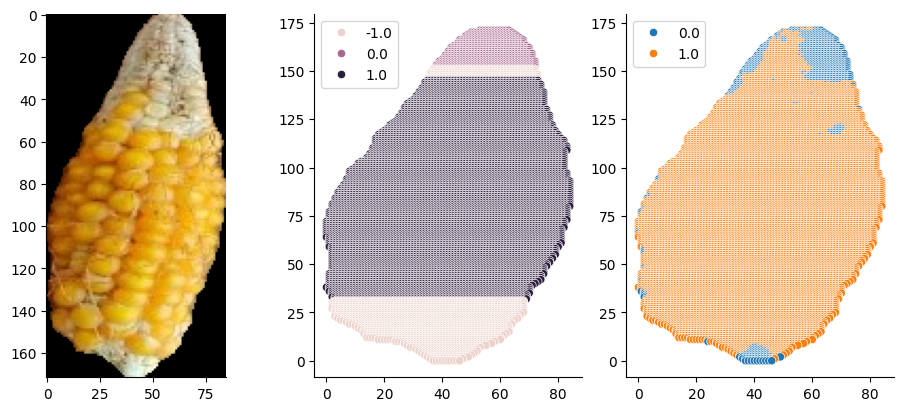

In [1239]:
axs = subplots(cols=3, rows=1, h=4, w=9)
obj = objects[2]['segmented_image']
axs[0].imshow(obj)

sns.scatterplot( x=coords[:, 4], y=np.max(coords[:, 3]) - coords[:, 3], hue=labels, ax=axs[1]);
sns.scatterplot( x=coords[:, 4], y=np.max(coords[:, 3]) - coords[:, 3], hue=preds, ax=axs[2]);

sns.despine()

## Predict disease in new objects

In [1086]:
obx = 5
obj = objects[obx]['segmented_image']
coords = objects[obx]['coords']

In [1087]:
coords['pred'] = clf.predict(coords[['R', 'G', 'B']])

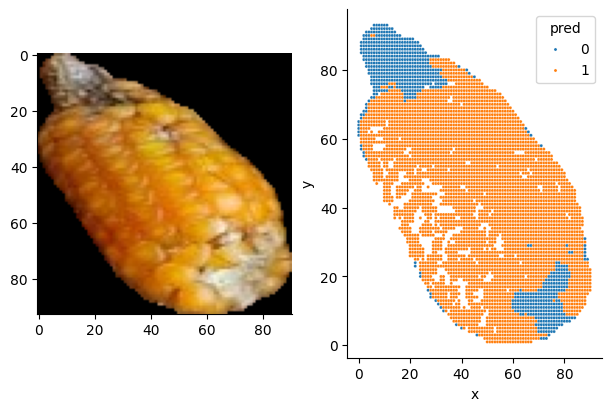

In [1089]:
axs = subplots(cols=2, rows=1, h=4, w=6)

axs[0].imshow(obj)
sns.scatterplot(data=coords, x='x', y='y', hue='pred', ax=axs[1], s=5);

sns.despine()